In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import skdim
import os.path
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import umap.umap_ as umap
from tqdm import tqdm
import json
import numpy as np
import math
from scipy.stats import mannwhitneyu
from json import JSONEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from rpy2.robjects import pandas2ri
from sklearn.manifold import TSNE

#pandas2ri.activate()

# Import data

In [81]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')

In [82]:
mirna = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')

In [83]:
mrna = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')

In [84]:
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')
len(proteins.columns)

216

# Import label

In [85]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

# Normalize data

In [86]:
def dataNormalization(scaler, data):
    scl = scaler()
    model = scl.fit(data)
    scaled_data = model.transform(data)
    
    return pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Filter feature with low variability

In [87]:
def filter_features_with_low_variability(data, alfa) -> pd.DataFrame:
    #Delete columns with standard deviation < alfa (0.10?)
    for column in data:
        if data[column].std() < alfa:
            #print(f'column: {column} has standard deviation < {alfa}, removed')
            data.drop(column, axis=1, inplace=True)
            
    return data

# Normalize and filter datasets

In [88]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

In [89]:
def create_data_normalized_filtered(data_dict, scaler, min_variance):
    dict_filtered_nornalize = {}
    for (key, value) in zip(data_dict, data_dict.values()):
        if key != 'cnv':
            dict_filtered_nornalize[key] = filter_features_with_low_variability(dataNormalization(MinMaxScaler, value), 0.05)
        else:
            dict_filtered_nornalize[key] = value
    return dict_filtered_nornalize

# Store and retrieve data normalize and filtered

In [90]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

In [91]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [92]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [93]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

In [94]:
print('DATI CARICATI CON SUCCESSO')

DATI CARICATI CON SUCCESSO


In [95]:
datasets = load_filtered_normalize_data(dataset_dict)

# Create concatenation of all dataset

In [96]:
whole_dataset = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mrna'], datasets['mirna']], axis=1)

In [97]:
datasets['whole_dataset'] = whole_dataset

# Create concatenation of dataset: proteins+mirna, proteins+mirna+mrna

In [98]:
proteins_mirna_dataset = pd.concat([datasets['proteins'], datasets['mirna']], axis=1)
datasets['proteins_mirna_dataset'] = proteins_mirna_dataset

In [99]:
proteins_mirna_mrna_dataset = pd.concat([datasets['proteins'], datasets['mirna'], datasets['mrna']], axis=1)
datasets['proteins_mirna_mrna_dataset'] = proteins_mirna_mrna_dataset

# Remove correlated feature using R code

In [100]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/RtmpqJqLRi/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7fcf72993440> [RTYPES.NILSXP]

In [101]:
robjects.r("""
library(doParallel)
""")

'doParall...,'parallel','iterators',...,'datasets','methods','base'


In [102]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

In [103]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

In [104]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['mirna'])

In [105]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mrna'])

In [106]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [107]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_whole_dataset = robjects.conversion.py2rpy(datasets['whole_dataset'])

In [108]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_dataset'])

In [109]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_mrna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_mrna_dataset'])

# Store data in local

In [110]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_with_r_function/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_with_r_function/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_with_r_function/{file_name}.json')
        return restore_result(file_name)

In [111]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [112]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [113]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [114]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [115]:
df_dataset_whole_dataset_removed = load_or_store_removed_correlated(r_whole_dataset, 'r_dataset_whole_dataset_removed')

In [116]:
df_dataset_proteins_mirna_removed = load_or_store_removed_correlated(r_proteins_mirna_dataset, 'r_proteins_mirna_dataset_removed')

In [117]:
df_dataset_proteins_mirna_removed

,hsa-mir-1292,hsa-mir-1243,hsa-mir-3615,hsa-mir-126,hsa-mir-29b-2,hsa-mir-517c,hsa-mir-3617,hsa-mir-491,hsa-let-7a-2,hsa-mir-1255a,...,hsa-mir-3606,4E-BP1,hsa-mir-224,hsa-mir-873,hsa-mir-7-2,p90RSK,hsa-mir-564,hsa-mir-198,hsa-mir-548a-3,hsa-mir-455
0,0.166667,0.0,0.035948,0.178660,0.160035,0.00000,0.000,0.025253,0.119289,0.033333,...,0.000000,0.239167,0.009050,0.027778,0.411765,0.231455,0.0,0.0,0.00,0.024350
1,0.055556,0.0,0.112745,0.149854,0.147891,0.06250,0.000,0.080808,0.139836,0.133333,...,0.000000,0.284533,0.032617,0.000000,0.000000,0.608802,0.0,0.0,0.00,0.038771
2,0.166667,0.2,0.039216,0.061618,0.073295,0.03125,0.000,0.080808,0.166448,0.000000,...,0.333333,0.314558,0.064668,0.000000,0.000000,0.464385,0.0,0.0,0.00,0.033032
3,0.055556,0.0,0.045752,0.241812,0.241895,0.00000,0.000,0.095960,0.237909,0.133333,...,0.000000,0.314115,0.008484,0.000000,0.008403,0.640495,0.0,0.0,0.00,0.048251
4,0.111111,0.0,0.027778,0.144255,0.208392,0.00000,0.000,0.050505,0.118014,0.066667,...,0.000000,0.491097,0.006599,0.000000,0.008403,0.645235,0.0,0.0,0.25,0.020209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.111111,0.0,0.016340,0.103097,0.112003,0.00000,0.000,0.050505,0.142673,0.000000,...,0.000000,0.338530,0.002074,0.000000,0.000000,0.377118,0.0,0.0,0.00,0.052492
623,0.166667,0.0,0.071895,0.191345,0.290903,0.12500,0.125,0.040404,0.088473,0.000000,...,0.000000,0.548152,0.017534,0.000000,0.008403,0.460639,0.0,0.0,0.00,0.120952
624,0.222222,0.0,0.122549,0.205112,0.238751,0.00000,0.000,0.080808,0.427864,0.200000,...,0.000000,0.432427,0.027526,0.027778,0.008403,0.663534,0.0,0.0,0.00,0.028092
625,0.166667,0.2,0.032680,0.209594,0.184430,0.00000,0.000,0.075758,0.141958,0.133333,...,0.000000,0.393421,0.007730,0.027778,0.008403,0.652143,0.0,0.0,0.00,0.033831


In [118]:
df_dataset_proteins_mirna_mrna_removed = load_or_store_removed_correlated(r_proteins_mirna_mrna_dataset, 'r_proteins_mirna_mrna_dataset_removed')

In [119]:
df_dataset_proteins_mirna_mrna_removed

,TAS2R50,ZNF33B,MAN1A2,SPDYA,CMTM1,SIRPD,RANBP1,MAMDC4,EMX2,STRAP,...,PTPLB,SCARF1,CCDC79,RBMXL3,S100A6,HECTD2,CALHM2,hsa-mir-1185-1,GTSF1,ELTD1
0,0.0,0.027072,0.057398,0.234526,0.203922,0.037736,0.132032,0.162562,0.068792,0.035733,...,0.041903,0.167345,0.117647,0.25,0.068429,0.024560,0.081491,0.066667,0.000312,0.041153
1,0.0,0.078233,0.076963,0.062470,0.199346,0.000000,0.161524,0.308937,0.166107,0.090928,...,0.029358,0.183225,0.000000,0.00,0.041713,0.071047,0.226284,0.066667,0.000937,0.073305
2,0.0,0.122254,0.095663,0.139342,0.224183,0.056604,0.153427,0.149191,0.067114,0.056585,...,0.036066,0.125407,0.000000,0.00,0.072602,0.055164,0.211127,0.066667,0.002185,0.042096
3,0.0,0.044727,0.035495,0.073009,0.080392,0.075472,0.067849,0.035890,0.028523,0.035209,...,0.006621,0.144544,0.058824,0.00,0.038791,0.018750,0.136056,0.266667,0.000624,0.041588
4,0.0,0.017341,0.090295,0.102861,0.034641,0.000000,0.256222,0.049965,0.001678,0.094073,...,0.015594,0.035831,0.000000,0.00,0.707351,0.041373,0.126248,0.000000,0.000000,0.012411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.0,0.145323,0.050126,0.254602,0.063399,0.000000,0.079952,0.541872,0.080537,0.034320,...,0.012806,0.164088,0.000000,0.00,0.080390,0.068103,0.218795,0.266667,0.000624,0.092031
623,0.0,0.035860,0.003723,0.081640,0.017647,0.000000,0.183771,0.053483,0.015101,0.022584,...,0.000000,0.032980,0.117647,0.00,0.044772,0.001162,0.181348,0.066667,0.005308,0.020685
624,0.0,0.134102,0.141286,0.057845,0.228758,0.018868,0.137828,0.281492,0.189597,0.091908,...,0.054360,0.366857,0.058824,0.00,0.076528,0.062602,0.367689,0.333333,0.003122,0.192771
625,0.0,0.076899,0.014631,0.095422,0.016340,0.037736,0.119417,0.134412,0.023490,0.042433,...,0.003049,0.177932,0.000000,0.00,0.209163,0.019292,0.227175,0.200000,0.001561,0.089853


In [120]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Intrinsic dimension estimation using the TwoNN algorithm

In [121]:
def execute_instrinsic_dimension_estimation(data):
    twoNN = skdim.id.TwoNN().fit(data)
    #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    lpca = skdim.id.TwoNN().fit_pw(data,
                                  n_neighbors = 100,
                                  n_jobs = 1)

    #get estimated intrinsic dimension
    return twoNN.dimension_, np.mean(lpca.dimension_pw_)

In [122]:
intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(df_proteins_removed)

In [123]:
intr_dimension_mirna, _ = execute_instrinsic_dimension_estimation(df_mirna_removed)

In [124]:
intr_dimension_mrna, _ = execute_instrinsic_dimension_estimation(df_mrna_removed)

In [125]:
intr_dimension_cnv, _ = execute_instrinsic_dimension_estimation(df_cnv_removed)

In [126]:
intr_dimension_whole_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_whole_dataset_removed)

In [127]:
intr_dimension_proteins_mirna_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_proteins_mirna_removed)

In [128]:
intr_dimension_proteins_mirna_mrna_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_proteins_mirna_mrna_removed)

In [129]:
print('CALCOLATE LE DIMENSIONI INTRINSECHE')

CALCOLATE LE DIMENSIONI INTRINSECHE


# Feature extraction using umap

In [130]:
def execute_umap(n_components, X, y):
    return umap.UMAP(n_neighbors=5, n_components=n_components, random_state=42).fit_transform(X, y)

In [131]:
r_proteins_umap = execute_umap(math.trunc(intr_dimension_proteins), df_proteins_removed, label)

In [132]:
r_miRNA_umap = execute_umap(math.trunc(intr_dimension_mirna), df_mirna_removed, label)

In [133]:
r_mRNA_umap = execute_umap(math.trunc(intr_dimension_mrna), df_mrna_removed, label)

In [134]:
r_cnv_umap = execute_umap(math.trunc(intr_dimension_cnv), df_cnv_removed, label)

In [135]:
r_whole_dataset_umap = execute_umap(math.trunc(intr_dimension_whole_dataset), df_dataset_whole_dataset_removed, label)

In [136]:
r_dataset_proteins_mirna_dataset_umap = execute_umap(math.trunc(intr_dimension_proteins_mirna_dataset), df_dataset_proteins_mirna_removed, label)

In [137]:
r_dataset_proteins_mirna_mrna_dataset_umap = execute_umap(math.trunc(intr_dimension_proteins_mirna_mrna_dataset), df_dataset_proteins_mirna_mrna_removed, label)

In [138]:
print('ESTRATTE LE FEATURE USANDO UMAP')

ESTRATTE LE FEATURE USANDO UMAP


# Train using intrinsic dimensionality and umap calculated on whole dataset

In [139]:
def train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}
    iterator = 1
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_fold, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_fold)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_Internal.pdf')
        
        iterator = iterator +1
    
    internal_average_precision_score = np.mean(average_precision_scores)
    
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated, name='Concat of predictions')

    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_average_precision_score), '{0:.4f}'.format(external_average_precision_score), clf.best_estimator_

In [140]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train proteins

('0.7191', '0.6941', RandomForestClassifier(max_leaf_nodes=5, n_estimators=51))

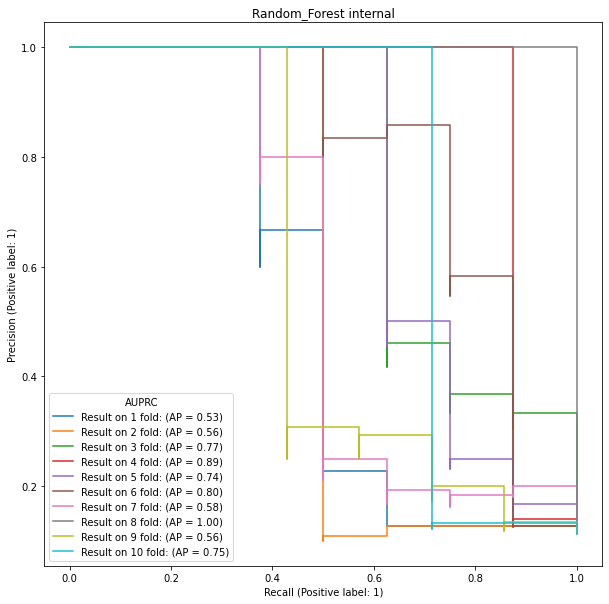

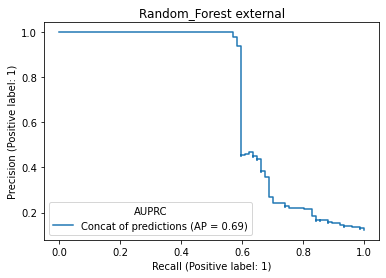

In [141]:
!mkdir 'Result/Experiments_using_R_Function_intrinsic_and_umap_whole_dataset'
!mkdir 'Result/Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/r_function_intrinsic_with_umap'
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_proteins_umap, label, 10, 'proteins', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train miRNA

('0.7873',
 '0.7851',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=10, n_estimators=101))

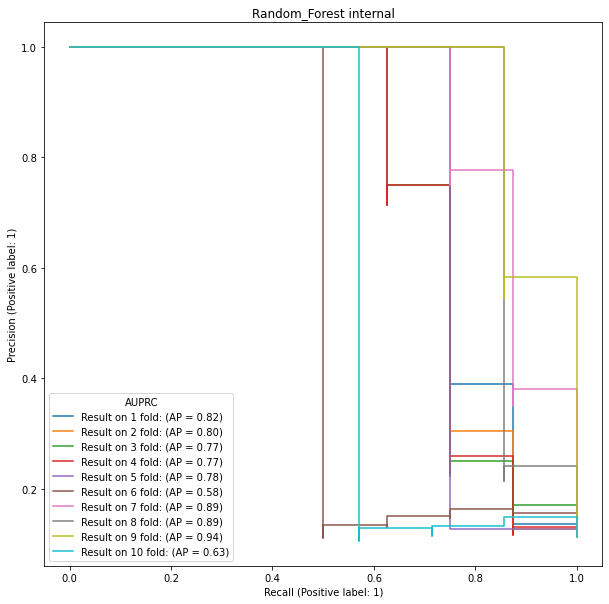

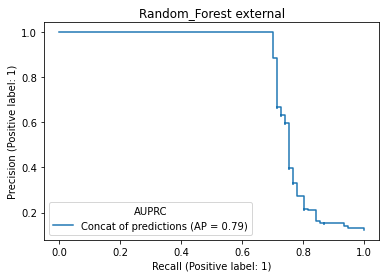

In [142]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_miRNA_umap, label, 10, 'mirna', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train mRNA

('0.6332',
 '0.6371',
 RandomForestClassifier(criterion='entropy', max_features=None, max_leaf_nodes=5,
                        n_estimators=51))

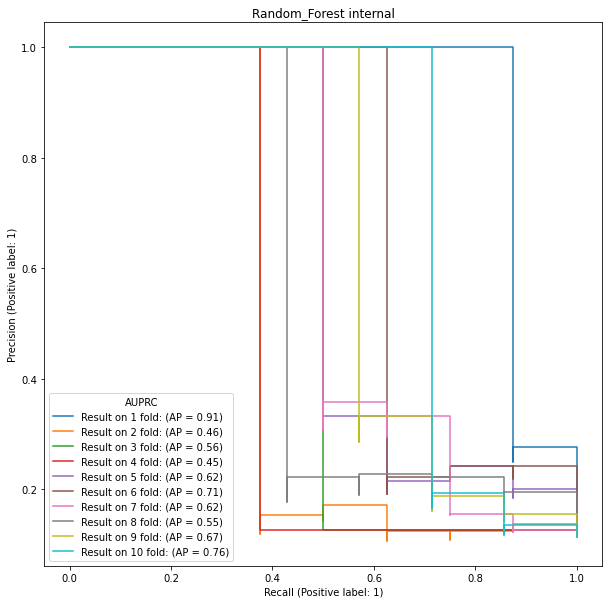

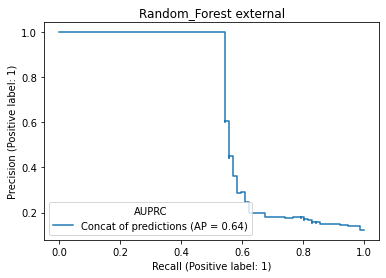

In [143]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_mRNA_umap, label, 10, 'mrna', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train cnv

('0.5523',
 '0.5631',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=5, n_estimators=101))

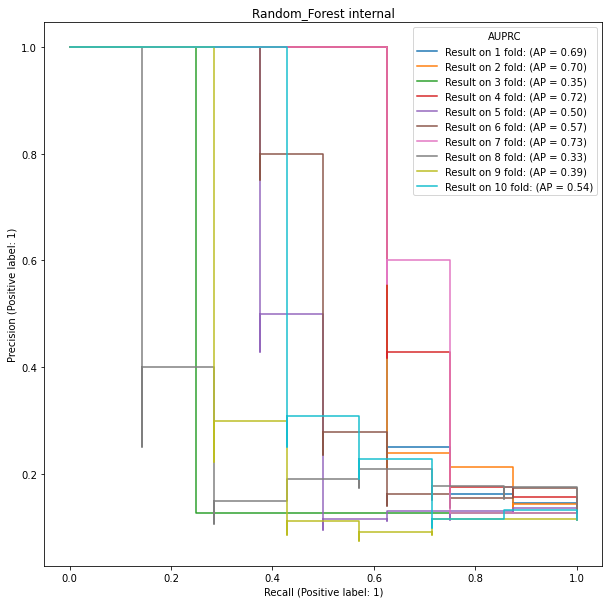

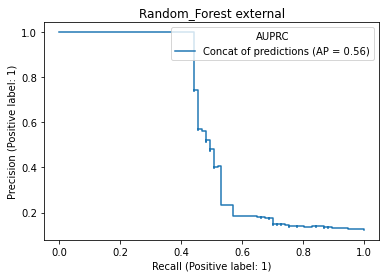

In [144]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_cnv_umap, label, 10, 'cnv', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train whole dataset

('0.7027', '0.6844', RandomForestClassifier(n_estimators=101))

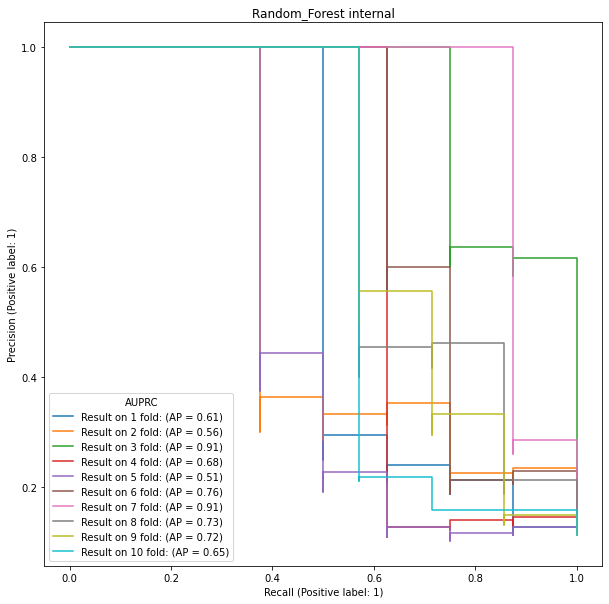

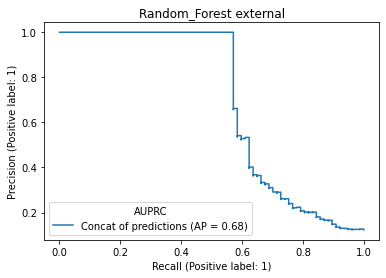

In [145]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_whole_dataset_umap, label, 10, 'whole_dataset',
    'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train proteins + mirna

('0.7348',
 '0.7326',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=5, n_estimators=51))

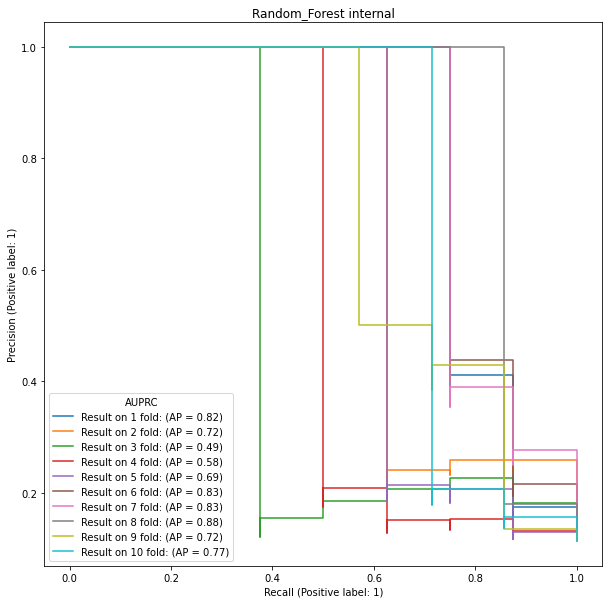

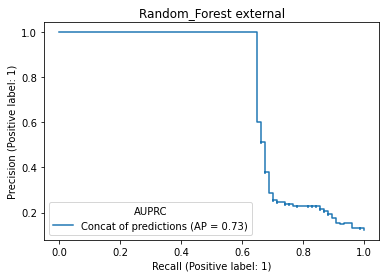

In [146]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_dataset_proteins_mirna_dataset_umap,
    label, 10, 'proteins_mirna', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train proteins+mirna+mrna

('0.6988',
 '0.6792',
 RandomForestClassifier(max_features=None, n_estimators=500))

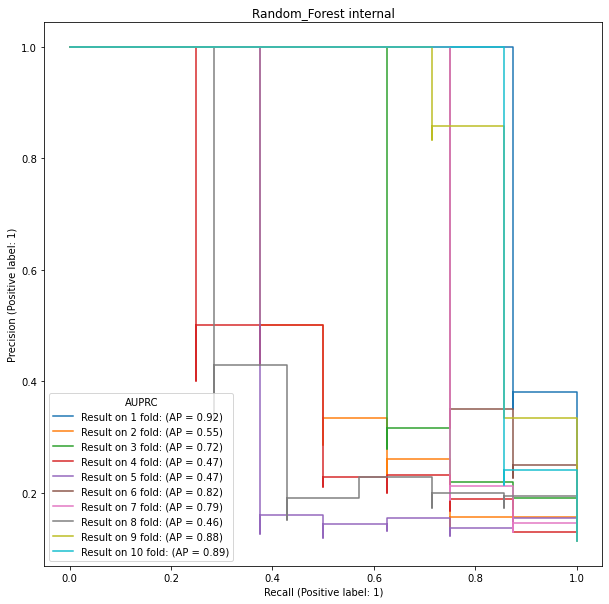

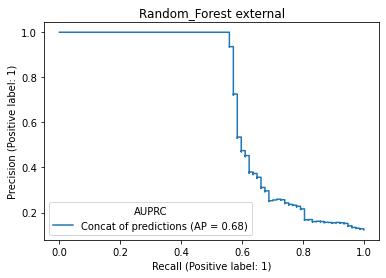

In [147]:
train_using_intrinsic_dimensionality_and_umap_on_whole_dataset(
    r_dataset_proteins_mirna_mrna_dataset_umap,
    label, 10, 'proteins_mirna_mrna',
    'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_intrinsic_and_umap_whole_dataset/')

# Train using intrinsic dimensionality and umap calculated on fold

In [148]:
def train_using_intrinsic_dimensionality_and_umap_on_fold(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    iterator = 1
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}
    X_numpy = X.to_numpy()
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X_numpy, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        X_train_intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(X_train_fold)

        X_train_r_proteins_umap = execute_umap(math.trunc(X_train_intr_dimension_proteins), X_train_fold, y_train_fold)
        X_test_r_proteins_umap = execute_umap(math.trunc(X_train_intr_dimension_proteins), X_test_fold, y_test_fold)
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_r_proteins_umap, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_r_proteins_umap)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_Internal.pdf')
        
        iterator = iterator +1
        
    
    internal_average_precision_score = np.mean(average_precision_scores)
    
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated, name='Concat of predictions')

    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
        
    
    return '{0:.4f}'.format(internal_average_precision_score), '{0:.4f}'.format(external_average_precision_score), clf.best_estimator_

# Train proteins

('0.3456',
 '0.1366',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=5, n_estimators=51))

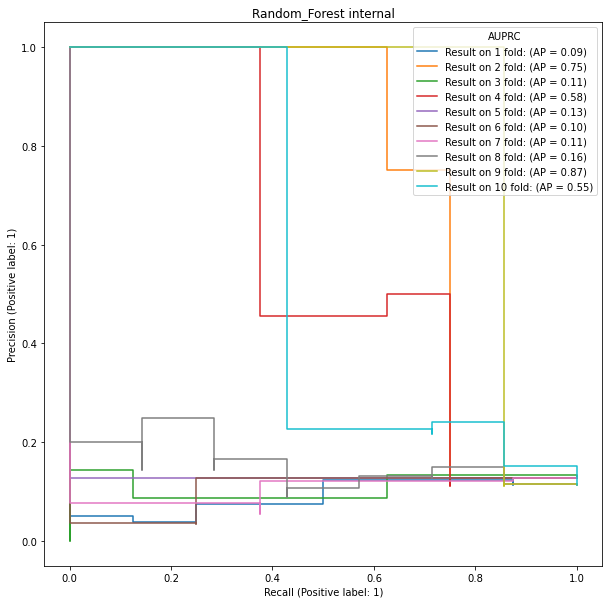

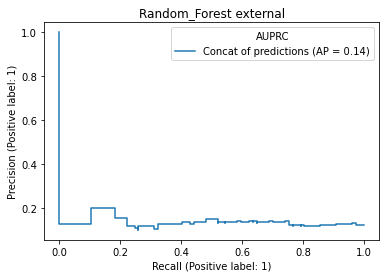

In [149]:
!mkdir 'Result/Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold'
!mkdir 'Result/Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/r_function_intrinsic_with_umap'
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_proteins_removed, label, 10, 'proteins', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train miRNA

('0.3834',
 '0.1746',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=5, n_estimators=51))

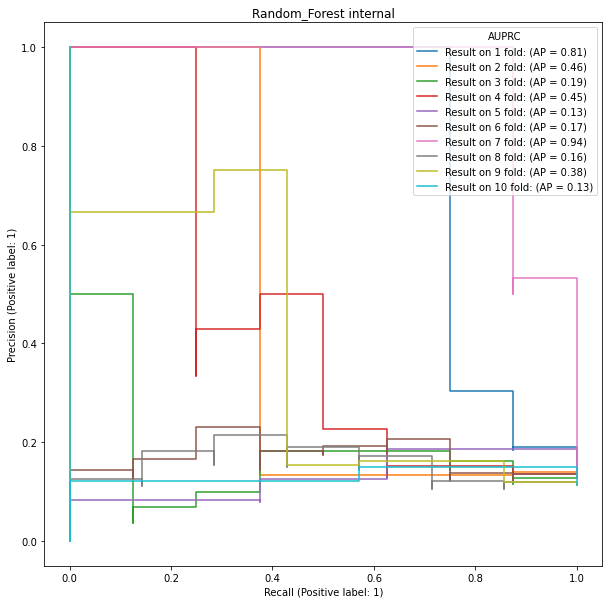

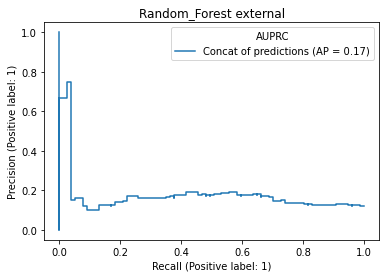

In [150]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_mirna_removed, label, 10, 'mirna', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train mRNA

('0.3202',
 '0.2068',
 RandomForestClassifier(max_features='log2', n_estimators=101))

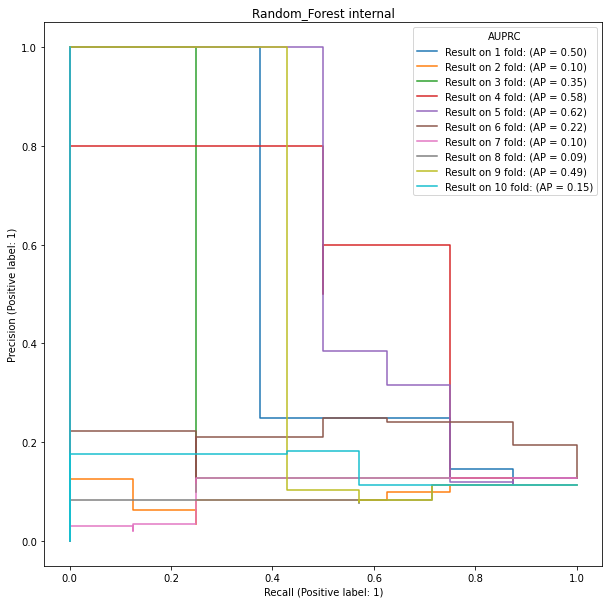

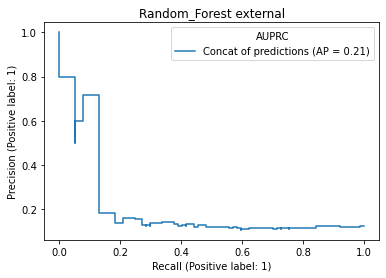

In [151]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_mrna_removed, label, 10, 'mrna', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train cnv

('0.1966',
 '0.1169',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=2, n_estimators=251))

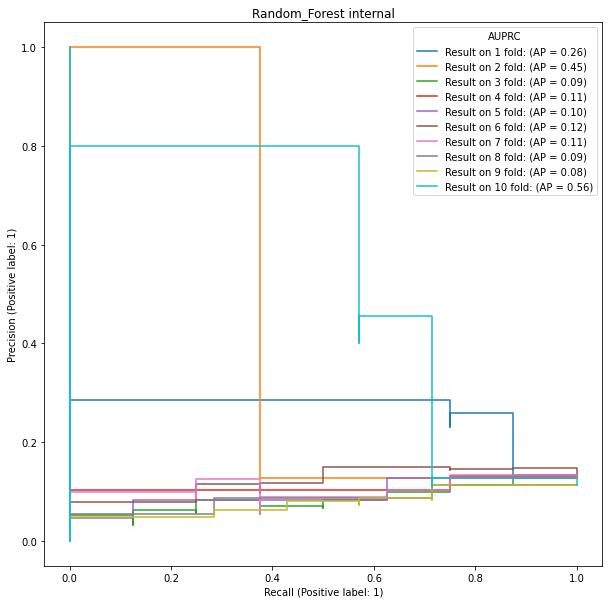

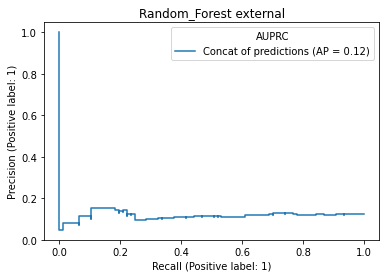

In [152]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_cnv_removed, label, 10, 'cnv', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train whole dataset

('0.2273',
 '0.1663',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=5, n_estimators=51))

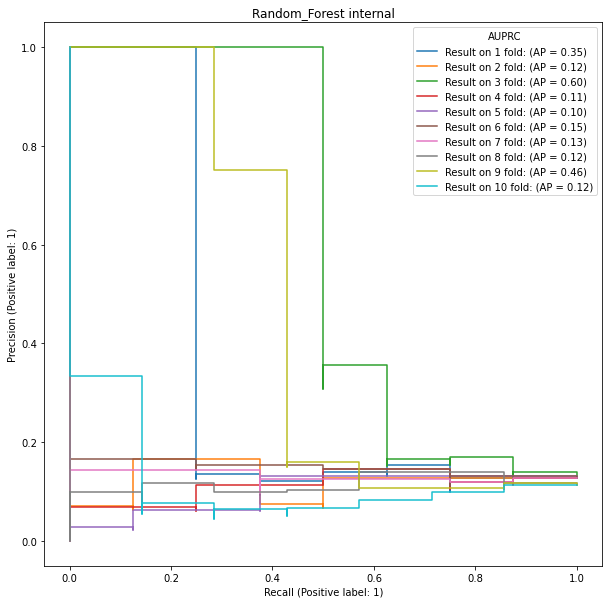

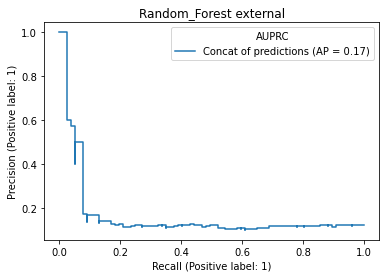

In [153]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_dataset_whole_dataset_removed, label, 10, 'whole_dataset', 'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train proteins + mirna

('0.3729',
 '0.1204',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=10, n_estimators=51))

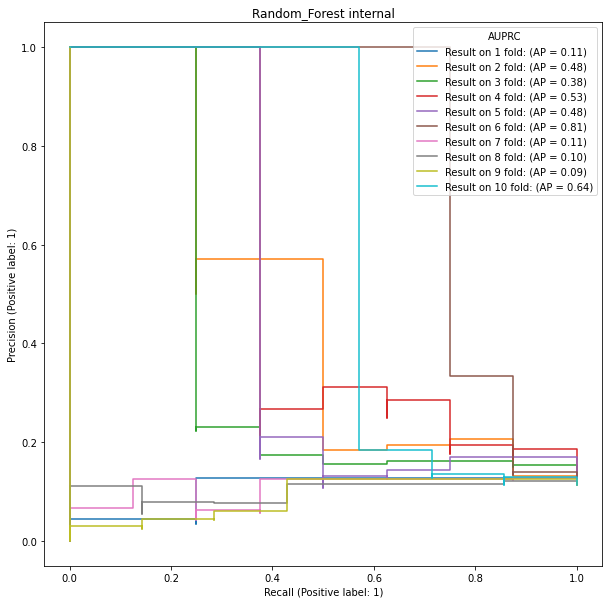

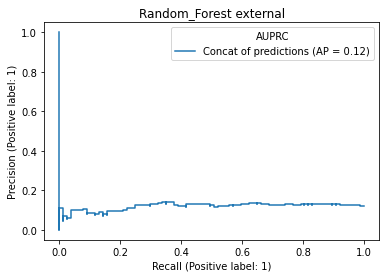

In [154]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_dataset_proteins_mirna_removed, label, 10, 'proteins_mirna', 
    'r_function_intrinsic_with_umap',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')

# Train proteins+mirna+mrna

('0.3631',
 '0.2191',
 RandomForestClassifier(max_features=None, max_leaf_nodes=10, n_estimators=251))

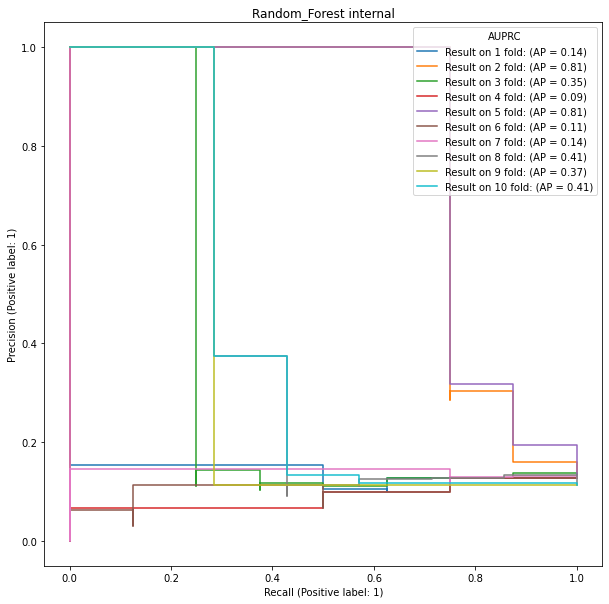

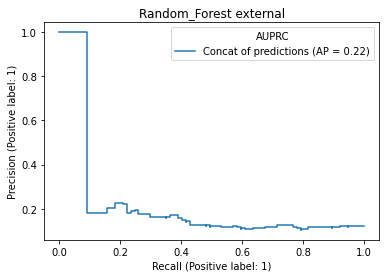

In [155]:
train_using_intrinsic_dimensionality_and_umap_on_fold(
    df_dataset_proteins_mirna_mrna_removed, label, 10,
    'proteins_mirna_mrna', 'r_function_intrinsic_with',
    'Experiments_using_R_Function_whole_intrinsic_and_umap_on_fold/')